## Colab Prep

Execute the following code cells to whenever you open/restart the notebook in Google Colab.

In [45]:
!pip install "polars[all]"

In [46]:
!wget https://github.com/WSU-DataScience/dsci_325_module_7_more_data_management_in_python/raw/main/sample_data.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [47]:
!unzip ./sample_data.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [48]:
!pip install more_polars

# Stacking and Unstacking Data

In [49]:
import polars as pl

## Reshaping data

Two ways

* We can **stack** data into a *tall* format.
* We can **unstack** data into a *long* format.

## (totally real and not at all made-up) Example - Quarterly Auto Sales

**Note** the last four columns are

* same measurements
* same units

In [62]:
sales = pl.read_csv("./sample_data/auto_sales.csv")
sales

shape: (5, 5)
┌─────────────┬─────────┬───────┬──────┬───────┐
│ Salesperson ┆ Compact ┆ Sedan ┆ SUV  ┆ Truck │
│ ---         ┆ ---     ┆ ---   ┆ ---  ┆ ---   │
│ str         ┆ i64     ┆ i64   ┆ i64  ┆ i64   │
╞═════════════╪═════════╪═══════╪══════╪═══════╡
│ Ann         ┆ 22      ┆ 18    ┆ 15   ┆ 12    │
│ Bob         ┆ 19      ┆ 12    ┆ 17   ┆ 20    │
│ Doug        ┆ 20      ┆ 13    ┆ null ┆ 20    │
│ Yolanda     ┆ 19      ┆ 8     ┆ 32   ┆ 15    │
│ Xerxes      ┆ 12      ┆ 23    ┆ 18   ┆ 9     │
└─────────────┴─────────┴───────┴──────┴───────┘

## Stacking measurements of the same type/units

<img src="https://github.com/WSU-DataScience/dsci_325_module_7_more_data_management_in_python/raw/main/img/stack_in_action.gif" width=600>

We can fix issues with informative column labels by stacking the data with `gather`

## A Stack by any other name ...

The act of stacking similar columns goes by various names.

* `polars` calls this `unpivot` [previously `melt`]
* JMP and Minitab call this *stack*
* Wickham/`tidyr`/`dfply` call this *gather*

I prefer **stack**, primarily because it makes it clear we are *melting*/*gathering* data vertically.

## Stacking data in `polars` with `unpivot`

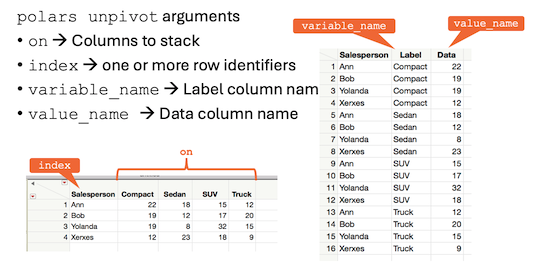

Syntax: `df.unpivot(on, index = ..., variable_name = ... , value_name = ...)`

In [64]:
sales_cols = ['Compact', 'Sedan', 'SUV', 'Truck']
sales_stacked = (sales 
                 .unpivot(sales_cols, 
                          index='Salesperson', 
                          variable_name='CarType', 
                          value_name='QrtSales')
                )
sales_stacked

shape: (20, 3)
┌─────────────┬─────────┬──────────┐
│ Salesperson ┆ CarType ┆ QrtSales │
│ ---         ┆ ---     ┆ ---      │
│ str         ┆ str     ┆ i64      │
╞═════════════╪═════════╪══════════╡
│ Ann         ┆ Compact ┆ 22       │
│ Bob         ┆ Compact ┆ 19       │
│ Doug        ┆ Compact ┆ 20       │
│ Yolanda     ┆ Compact ┆ 19       │
│ Xerxes      ┆ Compact ┆ 12       │
│ …           ┆ …       ┆ …        │
│ Ann         ┆ Truck   ┆ 12       │
│ Bob         ┆ Truck   ┆ 20       │
│ Doug        ┆ Truck   ┆ 20       │
│ Yolanda     ┆ Truck   ┆ 15       │
│ Xerxes      ┆ Truck   ┆ 9        │
└─────────────┴─────────┴──────────┘

## Unstacking Data with `pivot`

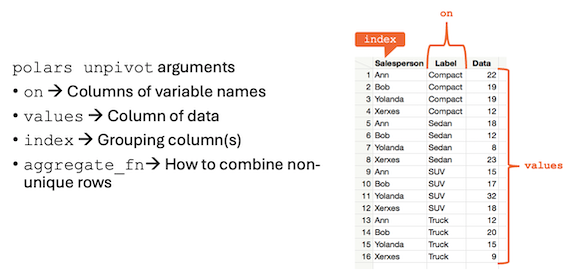

Syntax: `pivot(on, index = ..., values = ... , aggregate_fn = None)`

In [63]:
(sales_stacked
 .pivot('CarType', 
        index = 'Salesperson', 
        values = 'QrtSales')
)

shape: (5, 5)
┌─────────────┬─────────┬───────┬──────┬───────┐
│ Salesperson ┆ Compact ┆ Sedan ┆ SUV  ┆ Truck │
│ ---         ┆ ---     ┆ ---   ┆ ---  ┆ ---   │
│ str         ┆ i64     ┆ i64   ┆ i64  ┆ i64   │
╞═════════════╪═════════╪═══════╪══════╪═══════╡
│ Ann         ┆ 22      ┆ 18    ┆ 15   ┆ 12    │
│ Bob         ┆ 19      ┆ 12    ┆ 17   ┆ 20    │
│ Doug        ┆ 20      ┆ 13    ┆ null ┆ 20    │
│ Yolanda     ┆ 19      ┆ 8     ┆ 32   ┆ 15    │
│ Xerxes      ┆ 12      ┆ 23    ┆ 18   ┆ 9     │
└─────────────┴─────────┴───────┴──────┴───────┘

## Aggregating with `pivot` for non-unique entries

Sometimes, we want to pivot on data with more than one row per `index`.  In this case, we must provide a summary function that is used to aggregate the non-unique values into a single entry.

### Examples - Using `pivot` to total three month of data

The file `combined_auto_sales_apr_to_jun.csv` contains three months of data, which means there are up to three rows per `Salesperson`.  

In [71]:
combined_auto_sales = pl.read_csv('./sample_data/combined_auto_sales_apr_to_jun.csv')

combined_auto_sales

shape: (48, 3)
┌─────────────┬─────────┬──────────┐
│ Salesperson ┆ CarType ┆ QrtSales │
│ ---         ┆ ---     ┆ ---      │
│ str         ┆ str     ┆ i64      │
╞═════════════╪═════════╪══════════╡
│ Ann         ┆ Compact ┆ 22       │
│ Bob         ┆ Compact ┆ 19       │
│ Yolanda     ┆ Compact ┆ 19       │
│ Xerxes      ┆ Compact ┆ 12       │
│ Ann         ┆ Compact ┆ 18       │
│ …           ┆ …       ┆ …        │
│ Xerxes      ┆ Truck   ┆ 8        │
│ Ann         ┆ Truck   ┆ 12       │
│ Bob         ┆ Truck   ┆ 24       │
│ Yolanda     ┆ Truck   ┆ 17       │
│ Xerxes      ┆ Truck   ┆ 9        │
└─────────────┴─────────┴──────────┘

In this case, a `pivot` results in an exception letting us know there are non-unique entries.

In [ ]:
(combined_auto_sales
 .pivot('CarType', 
        index = 'Salesperson', 
        values = 'QrtSales')
)

We correct this issue by setting `aggregate_function='sum'` to compute the total overall duplicate rows

In [ ]:
(combined_auto_sales
 .pivot('CarType', 
        index = 'Salesperson', 
        values = 'QrtSales',
       aggregate_function='sum'
       )
)

While we could do this manually using `group_by` + `agg` + `unpivot`, this approach saves us two step!

In [ ]:
# Brute force approach ==> requires two extra steps.

(combined_auto_sales
 .group_by(['Salesperson', 'CarType'])
 .agg(QrtSales = pl.col('QrtSales').sum())
 .pivot('CarType', 
        index = 'Salesperson', 
        values = 'QrtSales'
       )
)

## Why Stack?

* Perform transformations on many columns.
* Fix problems with the Golden Rule

## Example - Switching Units on All Sales

Suppose your manager wants these numbers in *monthly* sales.  You could

1. Adjust each column with a separate formula
2. Stack --> Transform once --> Unstack

#### Method 1 - Brute-force Column Transformations

In [ ]:
pl.Config.with_columns_kwargs = True

(sales
 .with_columns(Compact = pl.col('Compact')/3,
                SUV = pl.col('SUV')/3,
                Sedan = pl.col('Sedan')/3,
                Truck = pl.col('Truck')/3,
               )
)

#### Method 2 - Stack-Transform-Unstack

In [41]:
(sales 
 .unpivot(sales_cols, 
         index='Salesperson', 
         variable_name='CarType', 
         value_name='QrtSales')
 .with_columns(MonSales = pl.col('QrtSales')/3)
 .drop('QrtSales')
 .pivot('CarType', 
        index = 'Salesperson', 
        values = 'MonSales'
       )
)

shape: (5, 5)
┌─────────────┬──────────┬──────────┬───────────┬──────────┐
│ Salesperson ┆ Compact  ┆ Sedan    ┆ SUV       ┆ Truck    │
│ ---         ┆ ---      ┆ ---      ┆ ---       ┆ ---      │
│ str         ┆ f64      ┆ f64      ┆ f64       ┆ f64      │
╞═════════════╪══════════╪══════════╪═══════════╪══════════╡
│ Ann         ┆ 7.333333 ┆ 6.0      ┆ 5.0       ┆ 4.0      │
│ Bob         ┆ 6.333333 ┆ 4.0      ┆ 5.666667  ┆ 6.666667 │
│ Doug        ┆ 6.666667 ┆ 4.333333 ┆ null      ┆ 6.666667 │
│ Yolanda     ┆ 6.333333 ┆ 2.666667 ┆ 10.666667 ┆ 5.0      │
│ Xerxes      ┆ 4.0      ┆ 7.666667 ┆ 6.0       ┆ 3.0      │
└─────────────┴──────────┴──────────┴───────────┴──────────┘

#### Method 3 - Unpack a `dict` comprehension

We will cover this more indepth in a future DSCI 326 module

In [ ]:
sales_cols = [col for col in sales.columns if col != 'Salesperson']

sales_cols

In [ ]:
(sales
 .with_columns(**{col:pl.col(col)/3 
                  for col in sales_cols}
               )
)

## Comparing the two methods

**Method 1:**
* More straight forward
* Lots of repeated code
* Doesn't scale ... imagine 100+ columns

**Method 2:**
* More complicated
* Scales well $\longrightarrow$ same code regardless of number of columns
* Easier with more complicated transformations

**Method 3:**
* More abstract
* By far the most sussinct

## <font color="red"> Exercise 7.2.1 </font>
    
**Task:** Load the `Artwork.csv` data and use the Stack-Transform-Unstack trick to convert all measurements in cm to mm.

**Hints.**
1. You will need to fix the `dtypes` for some of the measurement columns by passing the `artwork_dtypes` to `pl.read_csv`.
2. You will want to add an `ID` column to make the stack and unstack safe.
3. You can use `cols.from_` and `cols.to` to get the list of columns needed in `melt`.
4. `pivot` can't group by float columns, so you need to stack all measurements.
5. To process only the `cm` columns, use a `pl.when(cond).then(expr).otherwise(expr)` expression.
6. You should also replace the `cm` with `mm` in the label column (using the same trick in the last hint) before unstacking.

In [30]:
artwork_dtypes = {'Title': pl.datatypes.Utf8,
                  'Artist': pl.datatypes.Utf8,
                  'ConstituentID': pl.datatypes.Utf8,
                  'ArtistBio': pl.datatypes.Utf8,
                  'Nationality': pl.datatypes.Utf8,
                  'BeginDate': pl.datatypes.Utf8,
                  'EndDate': pl.datatypes.Utf8,
                  'Gender': pl.datatypes.Utf8,
                  'Date': pl.datatypes.Utf8,
                  'Medium': pl.datatypes.Utf8,
                  'Dimensions': pl.datatypes.Utf8,
                  'CreditLine': pl.datatypes.Utf8,
                  'AccessionNumber': pl.datatypes.Utf8,
                  'Classification': pl.datatypes.Utf8,
                  'Department': pl.datatypes.Utf8,
                  'DateAcquired': pl.datatypes.Utf8,
                  'Cataloged': pl.datatypes.Utf8,
                  'ObjectID': pl.datatypes.Int64,
                  'URL': pl.datatypes.Utf8,
                  'ThumbnailURL': pl.datatypes.Utf8,
                  'Circumference (cm)': pl.datatypes.Float64,
                  'Depth (cm)': pl.datatypes.Float64,
                  'Diameter (cm)': pl.datatypes.Float64,
                  'Height (cm)': pl.datatypes.Float64,
                  'Length (cm)': pl.datatypes.Float64,
                  'Weight (kg)': pl.datatypes.Float64,
                  'Width (cm)': pl.datatypes.Float64,
                  'Seat Height (cm)': pl.datatypes.Float64,
                  'Duration (sec.)': pl.datatypes.Float64}

Object `.pivot` not found.


In [32]:
# Your code here
artwork = pl.read_csv('https://github.com/MuseumofModernArt/collection/raw/main/Artworks.csv', schema_overrides=artwork_dtypes)
artwork.head()

shape: (5, 30)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Title     ┆ Artist    ┆ Constitue ┆ ArtistBio ┆ … ┆ Weight    ┆ Width     ┆ Seat      ┆ Duration │
│ ---       ┆ ---       ┆ ntID      ┆ ---       ┆   ┆ (kg)      ┆ (cm)      ┆ Height    ┆ (sec.)   │
│ str       ┆ str       ┆ ---       ┆ str       ┆   ┆ ---       ┆ ---       ┆ (cm)      ┆ ---      │
│           ┆           ┆ str       ┆           ┆   ┆ f64       ┆ f64       ┆ ---       ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ f64       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Ferdinand ┆ Otto      ┆ 6210      ┆ (Austrian ┆ … ┆ null      ┆ 168.9     ┆ null      ┆ null     │
│ sbrücke   ┆ Wagner    ┆           ┆ , 1841–19 ┆   ┆           ┆           ┆           ┆          │
│ Project,  ┆           ┆           ┆ 18)       ┆   ┆           ┆           ┆           ┆          │
│ Vien…     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ City of   ┆ Christian ┆ 7470      ┆ (French,  ┆ … ┆ null      ┆ 29.8451   ┆ null      ┆ null     │
│ Music,    ┆ de Portza ┆           ┆ born      ┆   ┆           ┆           ┆           ┆          │
│ National  ┆ mparc     ┆           ┆ 1944)     ┆   ┆           ┆           ┆           ┆          │
│ Superi…   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Villa     ┆ Emil      ┆ 7605      ┆ (Austrian ┆ … ┆ null      ┆ 31.8      ┆ null      ┆ null     │
│ project,  ┆ Hoppe     ┆           ┆ , 1876–19 ┆   ┆           ┆           ┆           ┆          │
│ outside   ┆           ┆           ┆ 57)       ┆   ┆           ┆           ┆           ┆          │
│ Vienna,…  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ The       ┆ Bernard   ┆ 7056      ┆ (French   ┆ … ┆ null      ┆ 50.8      ┆ null      ┆ null     │
│ Manhattan ┆ Tschumi   ┆           ┆ and       ┆   ┆           ┆           ┆           ┆          │
│ Transcrip ┆           ┆           ┆ Swiss,    ┆   ┆           ┆           ┆           ┆          │
│ ts Proj…  ┆           ┆           ┆ born      ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆           ┆ Switze…   ┆   ┆           ┆           ┆           ┆          │
│ Villa     ┆ Emil      ┆ 7605      ┆ (Austrian ┆ … ┆ null      ┆ 19.1      ┆ null      ┆ null     │
│ project,  ┆ Hoppe     ┆           ┆ , 1876–19 ┆   ┆           ┆           ┆           ┆          │
│ outside   ┆           ┆           ┆ 57)       ┆   ┆           ┆           ┆           ┆          │
│ Vienna,…  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [59]:
art_cols = ['Circumference (cm)','Depth (cm)', 'Diameter (cm)',
                  'Height (cm)',
                  'Length (cm)',
                  'Width (cm)',
                  'Seat Height (cm)']

In [72]:
(artwork
 .with_columns(pl.arange(0, len(artwork)).alias('ID'))
 .select('ID','Title','Circumference (cm)','Depth (cm)', 'Diameter (cm)',
                  'Height (cm)',
                  'Length (cm)',
                  'Width (cm)',
                  'Seat Height (cm)')
  .unpivot(art_cols, 
                          index=['ID','Title'], 
                          variable_name='Measurement', 
                          value_name='Measure_Value')
 .with_columns(Value_MM = pl.col('Measure_Value')*10)
 .with_columns(Measurement_MM = pl.when(pl.col('Measurement').str.contains('(cm)')).then(pl.col('Measurement').str.replace('(cm)','mm')).otherwise(pl.col('Measurement')))
 .drop(['Measurement','Measure_Value'])
  .pivot('Measurement_MM', 
        index = ['ID','Title'], 
        values = 'Value_MM')
)

shape: (156_633, 9)
┌────────┬──────────────┬──────────────┬───────┬───┬─────────┬────────┬──────────────┬─────────────┐
│ ID     ┆ Title        ┆ Circumferenc ┆ Depth ┆ … ┆ Height  ┆ Length ┆ Width (mm)   ┆ Seat Height │
│ ---    ┆ ---          ┆ e (mm)       ┆ (mm)  ┆   ┆ (mm)    ┆ (mm)   ┆ ---          ┆ (mm)        │
│ i64    ┆ str          ┆ ---          ┆ ---   ┆   ┆ ---     ┆ ---    ┆ f64          ┆ ---         │
│        ┆              ┆ f64          ┆ f64   ┆   ┆ f64     ┆ f64    ┆              ┆ f64         │
╞════════╪══════════════╪══════════════╪═══════╪═══╪═════════╪════════╪══════════════╪═════════════╡
│ 0      ┆ Ferdinandsbr ┆ null         ┆ null  ┆ … ┆ 486.0   ┆ null   ┆ 1689.0       ┆ null        │
│        ┆ ücke         ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│        ┆ Project,     ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│        ┆ Vien…        ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│ 1      ┆ City of      ┆ null         ┆ null  ┆ … ┆ 406.401 ┆ null   ┆ 298.451      ┆ null        │
│        ┆ Music,       ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│        ┆ National     ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│        ┆ Superi…      ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│ 2      ┆ Villa        ┆ null         ┆ null  ┆ … ┆ 343.0   ┆ null   ┆ 318.0        ┆ null        │
│        ┆ project,     ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│        ┆ outside      ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│        ┆ Vienna,…     ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│ 3      ┆ The          ┆ null         ┆ null  ┆ … ┆ 508.0   ┆ null   ┆ 508.0        ┆ null        │
│        ┆ Manhattan    ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│        ┆ Transcripts  ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│        ┆ Proj…        ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│ 4      ┆ Villa        ┆ null         ┆ null  ┆ … ┆ 384.0   ┆ null   ┆ 191.0        ┆ null        │
│        ┆ project,     ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│        ┆ outside      ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│        ┆ Vienna,…     ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│ …      ┆ …            ┆ …            ┆ …     ┆ … ┆ …       ┆ …      ┆ …            ┆ …           │
│ 156628 ┆ Musique Non  ┆ null         ┆ null  ┆ … ┆ null    ┆ null   ┆ null         ┆ null        │
│        ┆ Stop and     ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│        ┆ Kraftwerk…   ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│ 156629 ┆ Musique Non  ┆ null         ┆ null  ┆ … ┆ null    ┆ null   ┆ null         ┆ null        │
│        ┆ Stop and     ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│        ┆ Kraftwerk…   ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│ 156630 ┆ Musique Non  ┆ null         ┆ null  ┆ … ┆ null    ┆ null   ┆ null         ┆ null        │
│        ┆ Stop and     ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│        ┆ Kraftwerk…   ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│ 156631 ┆ Musique Non  ┆ null         ┆ null  ┆ … ┆ null    ┆ null   ┆ null         ┆ null        │
│        ┆ Stop and     ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│        ┆ Kraftwerk…   ┆              ┆       ┆   ┆         ┆        ┆              ┆             │
│ 156632 ┆ Musique Non  ┆ null         ┆ 